<a href="https://colab.research.google.com/github/whyhardt/closedloop_rl/blob/main/V2_Finalized_HBwith2terms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/dynamicslab/pysindy.git
!pip install -q pyro-ppl
# !pip uninstall numpyro
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro
!pip install -U jax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 8.6 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [3]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sympy as sp
import pyro

import random

import pysindy as ps
import pickle

from scipy.stats import truncnorm

import jax.numpy as jnp
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.infer as infer
from numpyro import distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import arviz as az
import sys
from numpyro.distributions import TruncatedDistribution
from numpyro.distributions import Normal

# ---------------------------Horseshoe----------------
from numpyro.distributions import Exponential
from numpyro.distributions import HalfCauchy
from numpyro.distributions import InverseGamma
from numpyro.distributions import Normal

In [4]:
DanielRepo_path = "/content/drive/MyDrive/IKW/DanielCodeGitRepo/Daiel_Code-main"
%cd /content/drive/MyDrive/IKW/DanielCodeGitRepo
sys.path.append(DanielRepo_path)

/content/drive/MyDrive/IKW/DanielCodeGitRepo


In [5]:
beta_names = ["Q_1","α","γ"]

# Data Generation

In [72]:
#@title Import libraries
import sys
import os
import warnings
import time
import pickle
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import Collection, Callable
import pickle
# warnings.filterwarnings("ignore")

# RL libraries
sys.path.append('resources')  # add source directoy to path
from resources import rnn, rnn_training, bandits, rnn_utils

# alphas =
# gamas =



def main(

  n_trials_per_session = 64,
  n_sessions = 128,

  # ground truth parameters
  alpha = 0.27,
  beta = 3,
  forget_rate = 0.,
  perseveration_bias = 0.,
  correlated_update = False,
  regret = False,
  confirmation_bias = False,
  reward_update_rule: Callable = None,

  # environment parameters
  n_actions = 2,
  sigma = 0.2,
  correlated_reward = False,
  non_binary_reward = False,
  ):
    time_str = int(time.time())
    # setup
    environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_reward=non_binary_reward, correlated_reward=correlated_reward)
    agent = bandits.AgentQ(alpha, beta, n_actions, forget_rate, perseveration_bias, correlated_update, regret, confirmation_bias)
    if reward_update_rule is not None:
        agent.set_reward_update(reward_update_rule)
    print('Setup of the environment and agent complete.')

    print('Creating the test dataset...', end='\r')
    dataset, experiment_list = bandits.create_dataset(
        agent=agent,
        environment=environment,
        n_trials_per_session=n_trials_per_session,
        n_sessions=n_sessions)

    print('Setup of datasets complete.')

    choices = []
    rewards = []
    qs = []
    reward_probs = []
    probs = []

    for session_id in range(len(experiment_list)):
      choices.append(experiment_list[session_id].choices)
      rewards.append(experiment_list[session_id].rewards)

      list_probs = []
      list_qs = []

      # get q-values from groundtruth
      qs_test, probs_test = bandits.get_update_dynamics(experiment_list[session_id], agent)
      list_probs.append(np.expand_dims(probs_test, 0))
      list_qs.append(np.expand_dims(qs_test, 0))

      # concatenate all choice probs and q-values
      probs_id = np.concatenate(list_probs, axis=0)
      qs_id = np.concatenate(list_qs, axis=0)

      probs.append(probs)
      qs.append(qs_id)

      reward_probs.append(np.stack([experiment_list[session_id].timeseries[:, i] for i in range(n_actions)], axis=0))

    return rewards, qs, choices


if __name__=='__main__':
  rewards, qs, choices = main(

  n_trials_per_session = 6,
  n_sessions = 1,

  # ground truth parameters
  alpha = 0.27,
  beta = 3,
  forget_rate = 0.,
  perseveration_bias = 0.,
  correlated_update = False,
  regret = False,
  confirmation_bias = False,
  #reward_update_rule: Callable = None,

  # environment parameters
  n_actions = 2,
  sigma = 0.2,
  correlated_reward = False,
  non_binary_reward = False,
  )

  print(len(qs))
  print(len(choices))
  print(len(rewards))
  print(qs)
  # print(choices)
  # print(rewards)

Setup of the environment and agent complete.
Setup of datasets complete.
1
1
1
[array([[[0.5      , 0.5      ],
        [0.635    , 0.5      ],
        [0.635    , 0.635    ],
        [0.635    , 0.46355  ],
        [0.46355  , 0.46355  ],
        [0.6083915, 0.46355  ]]])]


# Data Preprocessing

In [17]:
zip(rewards, qs, choices)

In [75]:
# @title Data Preprocessing
def preprocess_data(qs_list, rewards_list, choices_list,alpha,forget_rate):
  DF=pd.DataFrame()

  print("=================preprocess_data====================")
  for i in range(len(qs_list)):

    qs =  qs_list[i]
    rewards = rewards_list[i]
    choices = choices_list[i]

    qs=np.squeeze(qs)
    rewards=np.squeeze(rewards)
    choices=np.squeeze(choices)


    df=pd.DataFrame()



    df['QA_1']=qs[:,0]
    df['QB_1']=qs[:,1]
    df['R']=rewards
    df['Choice']=choices
    df['ActionA']=1-df['Choice']
    df['ActionB']=df['Choice']




    df['R-QA_1']=df['R']-df['QA_1']
    df['R-QB_1']=df['R']-df['QB_1']

    df['QA0']=df['QA_1'].iloc[0]
    df['QB0']=df['QB_1'].iloc[0]

    df['QA0-QA_1']=df['QA0']-df['QA_1']
    df['QB0-QB_1']=df['QB0']-df['QB_1']

    df['ActionA*(R-QA_1)']=df['ActionA']*df['R-QA_1']
    df['ActionB*(R-QB_1)']=df['ActionB']*df['R-QB_1']

    df['(1-ActionA)*(QA0-QA_1)']=(1-df['ActionA'])*df['QA0-QA_1']
    df['(1-ActionB)*(QB0-QB_1)']=(1-df['ActionB'])*df['QB0-QB_1']

    df['QA_1*QB_1']=df['QA_1']*df['QB_1']

    df['QA']=df['QA_1'].shift(-1)
    df['QB']=df['QB_1'].shift(-1)
    df['alpha'] = alpha
    df['forget_rate'] = forget_rate

    df.dropna(inplace=True)
    DF=pd.concat([DF, df[['QA','QA_1','ActionA*(R-QA_1)','(1-ActionA)*(QA0-QA_1)','alpha','forget_rate']]])
  time.sleep(1)
  print("preprocessing of data is complete")
  return DF
  # return df[['QB','QB_1','ActionB*(R-QB_1)','(1-ActionB)*(QB0-QB_1)','alpha','forget_rate']]

In [126]:
# @title Prepare Mix Data
def prepare_mix_data(AlphaN, ForgetrateN = None , ForgetRateV = None, AlphaV = None,
                     Alphas_mean = None, Alphas_std = None,
                     ForgetRate_mean = None,ForgetRate_std = None,
                     n_trials_per_session = None, n_sessions = None,XName_list=['QA_1','ActionA*(R-QA_1)']):

  real_alpha_mean= None
  real_forget_rate_mean = None
  real_alpha_std = None
  real_forget_rate_std = None
  if AlphaV is None:
    alphas =[x for x in np.random.normal(loc = Alphas_mean , scale = Alphas_std ,size = AlphaN) if x>0 and x<1]
  else:
    alphas = [AlphaV]

  # print(alphas)
  real_alpha_mean = np.mean(alphas)
  real_alpha_std = np.std(alphas)
  if ForgetRateV is None:
    forget_rates = [x for x in np.random.normal(ForgetRate_mean ,ForgetRate_std ,ForgetrateN) if x>0 and x<1]
  else:
    forget_rates = [ForgetRateV]
  real_forget_rate_mean = np.mean(forget_rates)
  real_forget_rate_std = np.std(forget_rates)

  # print(f"alphas = {alphas}")
  # print(f"forget_rates = {forget_rates}")
  df = pd.DataFrame()
  XMixedData_list=[]
  YMixedData_list=[]
  data_i=0
  for alpha in alphas:
    for forget_rate in forget_rates:
      data_i+=1
      print(f"The series {data_i} data is generated.")
      # print(f"alpha = {alpha}, forget_rate = {forget_rate}")
      oneIndv_df = pd.DataFrame()
      if __name__=='__main__':

        rewards_list, qs_list, choices_list = main(
        alpha = alpha,
        forget_rate = forget_rate,
        # perserveration_bias = 0.,
        # regret = False,
        n_trials_per_session = n_trials_per_session, #64,
        n_sessions = n_sessions,
        )

        # print(f"qs.shape = {qs.shape}")
      oneIndv_df = preprocess_data(qs_list, rewards_list, choices_list,alpha,forget_rate)
      #-------------------# I WANT TO REPLACE THIS CODE :---------
      # oneIndv_df['IndvID'] = data_i
      # df = pd.concat([df, oneIndv_df])
      # -----------------------------------------------------------
      print("---------start mixing data---------")
      XMixedData_list += [oneIndv_df[XName_list].to_numpy()]
      YMixedData_list += [oneIndv_df[['QA']].to_numpy()]


      print("---------end mixing data---------")
      # print("df shape = " ,df.shape)
  XMixedData_np = np.array(XMixedData_list)
  YMixedData_np = np.array(YMixedData_list)
  print("Preparing mix data is complete")
  RealDataInfo = [1,0,real_alpha_mean,real_alpha_std, real_forget_rate_mean, real_forget_rate_std]
  # return IDs,x_q,x_α,y,df, RealDataInfo
  return XMixedData_np, YMixedData_np, RealDataInfo

In [77]:
XMixedData_np, YMixedData_np, RealDataInfo = prepare_mix_data(AlphaN=2,
                          ForgetrateN=2,
                          ForgetRateV=None,
                          AlphaV=None,
                          Alphas_mean = .6,
                          Alphas_std = .1,
                          ForgetRate_mean = .2,
                          ForgetRate_std = .2,
                          n_trials_per_session = 3,
                          n_sessions = 2
                          )

The series 1 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 2 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
Preparing mix data is complete


# Models

In [78]:
# @title 1- Simple Hierarchical Regression Model with Gaussian as prioirs
rng_key = jax.random.PRNGKey(0)

def SimpleHBModel(x, y):
    n_targets = x.shape[1]
    n_features = x.shape[2]
    n_IDs = x.shape[0]

    μ_β = numpyro.sample("μ_β", dist.Normal(0., 1.), sample_shape=(n_IDs, n_features))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(1.), sample_shape=(n_IDs, n_features))

    #----------------Sample an α for each Indv-----------
    with numpyro.plate("plate_features_j", n_features):
      with numpyro.plate("plate_Indv_i", n_IDs):
        β = numpyro.sample("β", dist.Normal(μ_β,σ_β))
    #----------------Use the ampled α to sample the Obs of one Indv--
    # σ = numpyro.sample("σ", dist.HalfNormal(1.))
    σ = numpyro.sample("σ", dist.Exponential(1.))
    IDs = jnp.arange(n_IDs)

    y_est = jnp.einsum('ijk,ik->ij', x, β)

    with numpyro.plate("OneIndv_Obs", n_targets):
        numpyro.sample("obs", dist.Normal(y_est, σ), obs=y)


The series 1 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 2 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
Preparing mix data is complete


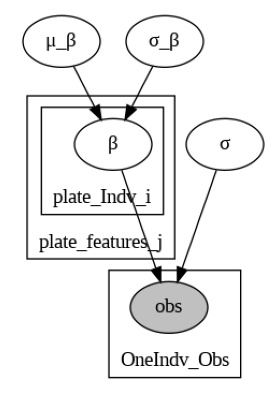

In [79]:

ForgetrateN=None
ForgetRateV=0
AlphaV=None
# ----------Ground Trun-----------------
AlphaN=3
Alphas_mean = .3
Alphas_std = .25
#---------------------------------------
ForgetRate_mean = 0
ForgetRate_std = 0
n_trials_per_session = 10
n_sessions = 1

#Preprocess Data
XMixedData_np, YMixedData_np, RealDataInfo = prepare_mix_data(AlphaN=AlphaN,
                          ForgetrateN=ForgetrateN,
                          ForgetRateV=ForgetRateV,
                          AlphaV=AlphaV,
                          Alphas_mean = Alphas_mean,
                          Alphas_std = Alphas_std,
                          ForgetRate_mean = ForgetRate_mean,
                          ForgetRate_std = ForgetRate_std,
                          n_trials_per_session = n_trials_per_session,
                          n_sessions = n_sessions
                          )

plt.figure(figsize=(5, 5),dpi=100)
graph = numpyro.render_model(SimpleHBModel, model_args=(XMixedData_np, np.squeeze(YMixedData_np)))
graph.render("Hierarchical_Horseshoe_Model", format="png")
plt.imshow(plt.imread("Hierarchical_Horseshoe_Model.png"))
plt.axis('off')
plt.show()

In [80]:
# @title HS


def _sample_reg_horseshoe(tau: float, c_sq: float, shape: tuple[int, ...],name = "betaH"):

    lamb = numpyro.sample(name+"lambda", HalfCauchy(1.0), sample_shape=shape)
    lamb_squiggle = jnp.sqrt(c_sq) * lamb / jnp.sqrt(c_sq + tau**2 * lamb**2)
    betaH = numpyro.sample(
        name,
        Normal(jnp.zeros_like(lamb_squiggle), jnp.sqrt(lamb_squiggle**2 * tau**2)),
    )
    return betaH



def HSModel1(x, y):
    n_targets = x.shape[1]
    n_features = x.shape[2]
    n_IDs = x.shape[0]
    slab_shape_nu = 4
    slab_shape_s = 2
    noise_hyper_lambda = 1
    sparsity_coef_tau0 = 0.1

    # sample the horseshoe hyperparameters.
    τ_μ = numpyro.sample("τ_μ", HalfCauchy(sparsity_coef_tau0), sample_shape=(n_IDs, n_features))
    c_sq_μ = numpyro.sample("c_sq_μ",InverseGamma(slab_shape_nu / 2, slab_shape_nu / 2 * slab_shape_s**2), sample_shape=(n_IDs, n_features))
    μ_β = _sample_reg_horseshoe(τ_μ, c_sq_μ,(n_IDs, n_features),"μ_β")

    σ_β = numpyro.sample("σ_β", dist.HalfNormal(1.), sample_shape=(n_IDs, n_features))


    #----------------Sample an α for each Indv-----------
    with numpyro.plate("plate_features_j", n_features):
          with numpyro.plate("plate_Indv_i", n_IDs):
            β = numpyro.sample("β", dist.Normal(μ_β,σ_β))
    #----------------Use the ampled α to sample the Obs of one Indv--
    σ = numpyro.sample("σ", dist.HalfNormal(1.))
    IDs = jnp.arange(n_IDs)
    y_est = jnp.einsum('ijk,ik->ij', x, β)

    with numpyro.plate("OneIndv_Obs", n_targets):
        numpyro.sample("obs", dist.Normal(y_est, σ), obs=y)

The series 1 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 2 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
Preparing mix data is complete


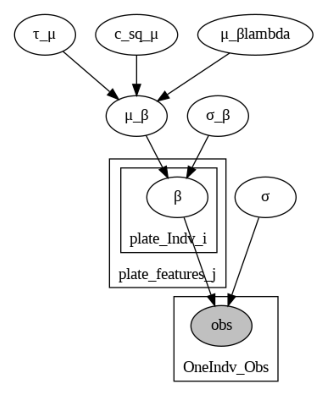

In [81]:

ForgetrateN=None
ForgetRateV=0
AlphaV=None
# ----------Ground Trun-----------------
AlphaN=3
Alphas_mean = .3
Alphas_std = .25
#---------------------------------------
ForgetRate_mean = 0
ForgetRate_std = 0
n_trials_per_session = 10
n_sessions = 1

#Preprocess Data
XMixedData_np, YMixedData_np, RealDataInfo = prepare_mix_data(AlphaN=AlphaN,
                          ForgetrateN=ForgetrateN,
                          ForgetRateV=ForgetRateV,
                          AlphaV=AlphaV,
                          Alphas_mean = Alphas_mean,
                          Alphas_std = Alphas_std,
                          ForgetRate_mean = ForgetRate_mean,
                          ForgetRate_std = ForgetRate_std,
                          n_trials_per_session = n_trials_per_session,
                          n_sessions = n_sessions
                          )

plt.figure(figsize=(5, 5),dpi=100)
graph = numpyro.render_model(HSModel1, model_args=(XMixedData_np, np.squeeze(YMixedData_np)))
graph.render("Hierarchical_Horseshoe_Model", format="png")
plt.imshow(plt.imread("Hierarchical_Horseshoe_Model.png"))
plt.axis('off')
plt.show()

# RUN

## Run-1

In [127]:


# ----------Ground Trun-----------------
AlphaV=None
AlphaN=20
Alphas_mean = .6
Alphas_std = .15
#---------------------------------------
ForgetRate_mean = 0.3
ForgetRate_std = .2
ForgetrateN=20
ForgetRateV=None
n_trials_per_session = 100
n_sessions = 1

#Preprocess Data
XMixedData_np, YMixedData_np, RealDataInfo = prepare_mix_data(AlphaN=AlphaN,
                          ForgetrateN=ForgetrateN,
                          ForgetRateV=ForgetRateV,
                          AlphaV=AlphaV,
                          Alphas_mean = Alphas_mean,
                          Alphas_std = Alphas_std,
                          ForgetRate_mean = ForgetRate_mean,
                          ForgetRate_std = ForgetRate_std,
                          n_trials_per_session = n_trials_per_session,
                          n_sessions = n_sessions,
                          XName_list=['QA_1','ActionA*(R-QA_1)','(1-ActionA)*(QA0-QA_1)']
                          )

The series 1 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 2 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 3 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 4 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing 

In [128]:
XMixedData_np.shape

(380, 99, 3)

In [129]:
# Variational Inference
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer import  SVI, Trace_ELBO, Predictive
from numpyro.optim import Adam
model = HSModel1 #HorseshoeHierarchicalRegressionModel
guide = AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), loss=Trace_ELBO())
PRNG_key = 1
rng_key = jax.random.PRNGKey(PRNG_key)
svi_result = svi.run(rng_key, 2000, x = XMixedData_np, y = np.squeeze(YMixedData_np))
vi_samples = svi_result.params

<ipython-input-129-54dfe1ce1e62>:10: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(rng_key, 2000, x = XMixedData_np, y = np.squeeze(YMixedData_np))
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:193: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 2000/2000 [00:09<00:00, 200.89it/s, init loss: 140027.5781, avg. loss [1901-2000]: -209135.0430]


In [130]:
vi_samples['β_auto_loc'].shape

(380, 3)

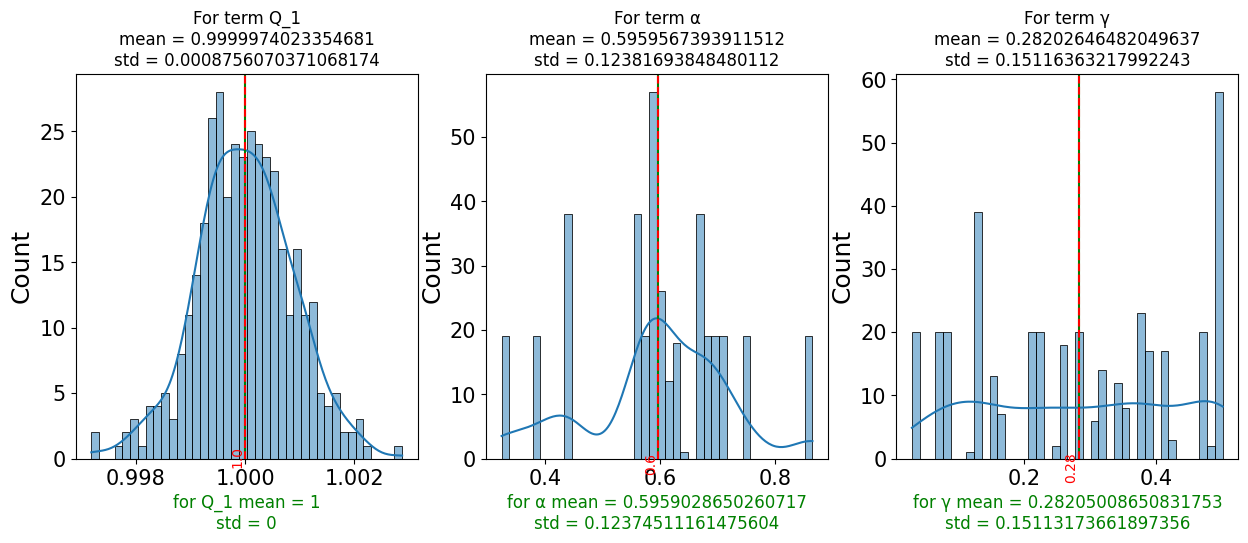

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i_β in range(3):

  β0_Est = [samp[i_β] for samp in vi_samples['β_auto_loc']]
  β0_Est = [float(betaSam)for betaSam in β0_Est]
  mean_v = np.mean(β0_Est)
  mean_r = round(mean_v,2)
  sns.histplot(β0_Est, kde=True, bins=40,ax=ax[i_β])
  fontdict={"size":12}

  ax[i_β].set_title(f"For term {beta_names[i_β]}\nmean = {mean_v}\nstd = {np.std(β0_Est)}",fontdict=fontdict)

  ax[i_β].axvline(x=RealDataInfo[(i_β)*2], color='green', linestyle='-')
  ax[i_β].axvline(x=mean_v, color='red', linestyle='--')
  ax[i_β].text(mean_v, 0.99, f'{mean_r}', color='r', ha='right', va='top', rotation=90)

  ax[i_β].set_xlabel(f"for {beta_names[i_β] } mean = {RealDataInfo[(i_β)*2]}\nstd = {RealDataInfo[(i_β)*2+1]}",
                      color='green',size=12)
plt.show()

## Run-2

In [135]:


# ----------Ground Trun-----------------
AlphaV=None
AlphaN=20
Alphas_mean = .4
Alphas_std = .15
#---------------------------------------
ForgetRate_mean = 0.7
ForgetRate_std = .2
ForgetrateN=10
ForgetRateV=None
n_trials_per_session = 50
n_sessions = 6

#Preprocess Data
XMixedData_np, YMixedData_np, RealDataInfo = prepare_mix_data(AlphaN=AlphaN,
                          ForgetrateN=ForgetrateN,
                          ForgetRateV=ForgetRateV,
                          AlphaV=AlphaV,
                          Alphas_mean = Alphas_mean,
                          Alphas_std = Alphas_std,
                          ForgetRate_mean = ForgetRate_mean,
                          ForgetRate_std = ForgetRate_std,
                          n_trials_per_session = n_trials_per_session,
                          n_sessions = n_sessions,
                          XName_list=['QA_1','ActionA*(R-QA_1)','(1-ActionA)*(QA0-QA_1)']
                          )

The series 1 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 2 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 3 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing data---------
---------end mixing data---------
The series 4 data is generated.
Setup of the environment and agent complete.
Setup of datasets complete.
=================preprocess_data====================
preprocessing of data is complete
---------start mixing 

In [109]:
XMixedData_np.shape

(200, 294, 3)

In [136]:
# Variational Inference
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer import  SVI, Trace_ELBO, Predictive
from numpyro.optim import Adam
model = HSModel1 #HorseshoeHierarchicalRegressionModel
guide = AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), loss=Trace_ELBO())
PRNG_key = 1
rng_key = jax.random.PRNGKey(PRNG_key)
svi_result = svi.run(rng_key, 2000, x = XMixedData_np, y = np.squeeze(YMixedData_np))
vi_samples = svi_result.params

<ipython-input-136-54dfe1ce1e62>:10: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  svi_result = svi.run(rng_key, 2000, x = XMixedData_np, y = np.squeeze(YMixedData_np))
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/jax/_src/linear_util.py:193: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))
100%|██████████| 2000/2000 [00:10<00:00, 188.11it/s, init loss: 134338.5312, avg. loss [1901-2000]: -358649.6225]


In [137]:
vi_samples['β_auto_loc'].shape

(200, 3)

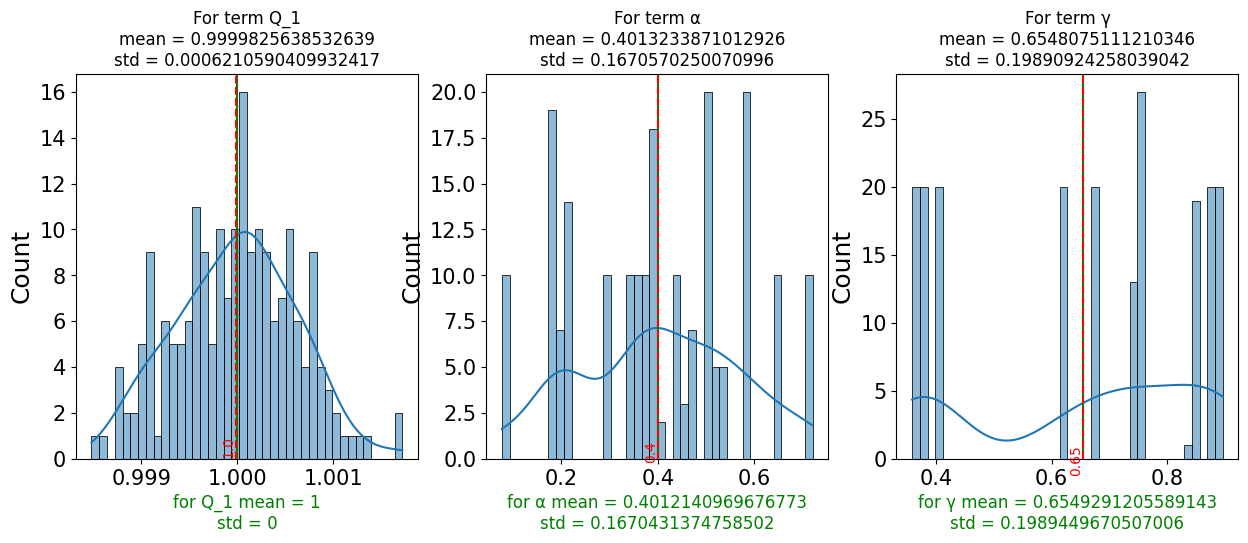

In [138]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i_β in range(3):

  β0_Est = [samp[i_β] for samp in vi_samples['β_auto_loc']]
  β0_Est = [float(betaSam)for betaSam in β0_Est]
  mean_v = np.mean(β0_Est)
  mean_r = round(mean_v,2)
  sns.histplot(β0_Est, kde=True, bins=40,ax=ax[i_β])
  fontdict={"size":12}

  ax[i_β].set_title(f"For term {beta_names[i_β]}\nmean = {mean_v}\nstd = {np.std(β0_Est)}",fontdict=fontdict)

  ax[i_β].axvline(x=RealDataInfo[(i_β)*2], color='green', linestyle='-')
  ax[i_β].axvline(x=mean_v, color='red', linestyle='--')
  ax[i_β].text(mean_v, 0.99, f'{mean_r}', color='r', ha='right', va='top', rotation=90)

  ax[i_β].set_xlabel(f"for {beta_names[i_β] } mean = {RealDataInfo[(i_β)*2]}\nstd = {RealDataInfo[(i_β)*2+1]}",
                      color='green',size=12)
plt.show()